# Tutorial 2: Hair follicle (ATAC-seq + RNA-seq)

This tutorial investigates a single-cell multimodal hair follicle dataset from [Ma et al., 2020](https://www.sciencedirect.com/science/article/pii/S0092867420312538). Data comes from female mouse dorsal skin and consists of two single-cell modalities: ATAC-seq (chromatin accessibility, raw data available [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4156597)) and RNA-seq (gene expression, raw data available [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4156608)).

In Tutorial 1, you visualized MDM components with both ForceAtlas2 and UMAP. Ocelli implements an extended force-directed layout approach that uses transition probabilities (velocities) between cells. There are a few methods modeling single-cell velocities, such as [Velocyto](https://doi.org/10.1038/s41586-018-0414-6), [scVelo](https://www.nature.com/articles/s41587-020-0591-3), or [Waddington Optimal Transport](https://www.sciencedirect.com/science/article/pii/S009286741930039X). In this tutorial, you will construct the MDM embedding of the hair follicle dataset and learn how to use RNA dynamics information when creating the graph for force-directed data visualization.

## Loading and preprocessing data

In [1]:
import anndata as ad

SEED = 17

We generated the RNA-seq annotated matrix from raw BAM files with [Velocyto](https://doi.org/10.1038/s41586-018-0414-6) and then filtered cells and genes. Filtering steps are described in detail in the paper. The resulting count matrix has 7,160 cells and 6,731 genes, together with unspliced (`adata.layers['unspliced']`) and spliced (`adata.layers['spliced']`) expression layers needed for RNA velocity calculation. The RNA-seq annotated matrix is available for download [here](https://doi.org/10.6084/m9.figshare.22700056.v1).

In [2]:
rnaseq = ad.read_h5ad('hair_follicle_RNAseq.h5ad')

rnaseq

AnnData object with n_obs × n_vars = 7160 × 6731
    obs: 'celltype', 'doublet_scores', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

Ocelli's data preprocessing is based on topic modeling, a data compression approach that organizes features into cohesive groups (topics). Each cell is modeled as a topic mixture, with highly-expressed topics being more probable. These distributions form highly-compressed and information-rich latent spaces on which we train models (they are already cell-normalized).

Ocelli uses Latent Dirichlet Allocation (LDA), a generative Bayesian topic model, which has become the golden standard in the field. You should run LDA on raw (unnormalized and unscaled) count matrices. However, feel free to filter out low-quality cells/features. LDA has two major parameters: `n_components` (the number of topics) and `max_iter` (the maximum number of LDA's training iterations).

Compute 50 LDA topics on the RNA-seq count matrix.

In [3]:
import ocelli as oci

oci.pp.LDA(rnaseq, n_components=50, max_iter=50, random_state=SEED, verbose=1)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

Estimate RNA velocities with [scVelo](https://scvelo.readthedocs.io) on 1,000 log-normalized highly variable genes.

In [4]:
import scvelo as scv

scv.pp.normalize_per_cell(rnaseq, counts_per_cell_after=10000)
scv.pp.filter_genes_dispersion(rnaseq, n_top_genes=1000)
scv.pp.log1p(rnaseq)

scv.tl.velocity(rnaseq, mode='stochastic')
scv.tl.velocity_graph(rnaseq)

Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/7160 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


We generated the ATAC-seq count matrix with [Signac](https://stuartlab.org/signac/index.html) by mapping chromatin accessibility fragments to gene regions, including the 2kb upstream. Next, we filtered genes (details in the paper), resulting in 17,495 genes. The ATAC-seq annotated matrix is available for download [here](https://doi.org/10.6084/m9.figshare.22700056.v1).

In [5]:
atacseq = ad.read_h5ad('hair_follicle_ATACseq.h5ad')

atacseq

AnnData object with n_obs × n_vars = 7160 × 17495
    var: 'n_counts'

Compute 50 LDA topics on the ATAC-seq count matrix.

In [6]:
oci.pp.LDA(atacseq, n_components=50, max_iter=50, random_state=SEED, verbose=1)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

## Multimodal Diffusion Maps

To proceed to multimodal analysis, you must create a joint `AnnData` object for both modalities. It must include preprocessed modality arrays saved in `adata.obsm` and a list of their keys stored in `adata.uns`. Everything else is optional; in this case, also cell metadata (barcodes and cell type annotations) and RNA velocity data are included.

In [7]:
from scipy.sparse import csr_matrix

# empty AnnData object
adata = ad.AnnData(csr_matrix(([],([],[])), shape=(7160, 1000)))

# modality arrays
adata.obsm['RNA-seq'] = rnaseq.obsm['X_lda']
adata.obsm['ATAC-seq'] = atacseq.obsm['X_lda']
adata.uns['modalities'] = ['RNA-seq', 'ATAC-seq']

# cell metadata
adata.obs.index = list(rnaseq.obs.index)
adata.obs['celltype'] = list(rnaseq.obs['celltype'])

# RNA velocity data
adata.uns['velocity_graph'] = rnaseq.uns['velocity_graph']
adata.uns['velocity_graph_neg'] = rnaseq.uns['velocity_graph_neg']
adata.layers['velocity'] = rnaseq.layers['velocity']

adata

AnnData object with n_obs × n_vars = 7160 × 1000
    obs: 'celltype'
    uns: 'modalities', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'RNA-seq', 'ATAC-seq'
    layers: 'velocity'

Follow the MDM workflow: compute nearest neighbors across modalities, multimodal weights, and the low-dimensional MDM embedding.

In [8]:
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.weights(adata, random_state=SEED, verbose=True)
oci.tl.MDM(adata, n_components=20, random_state=SEED, verbose=True)

[RNA-seq]	20 nearest neighbors calculated.
[ATAC-seq]	20 nearest neighbors calculated.


2023-02-09 17:14:34,418	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal weights estimated.


2023-02-09 17:14:39,984	INFO worker.py:1518 -- Started a local Ray instance.


[RNA-seq]	Unimodal Markov chain calculated.
[ATAC-seq]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
20 Multimodal Diffusion Maps components calculated.


## Visualizing MDM components with RNA velocity

With Ocelli, you can incorporate transition probabilities between cells (such as RNA velocities) when constructing low-dimensional embeddings. `oci.tl.transitions` builds the graph for force-directed data visualization, which connects a cell to its nearest neighbors with the highest transition probabilities. If the neighborhood has too few cells with non-zero transitions, edges are created towards the nearest neighbors. You may interpret the transitions graph as follows: the MDM latent space represents a global multimodal structure, while RNA transitions align cells locally (within cells' neighborhoods) along a velocity stream.

In [9]:
oci.pp.neighbors(adata, x=['X_mdm'], n_neighbors=100, verbose=True)
oci.tl.transitions_graph(adata, x='X_mdm', transitions='velocity_graph', n_edges=3, 
                         verbose=True)

[X_mdm]	100 nearest neighbors calculated.
Transitions-based graph constructed.


Compute a 3D force-directed layout embedding.

In [10]:
oci.tl.FA2(adata, n_components=3, random_state=SEED)

Feb 09, 2023 5:14:58 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Feb 09, 2023 5:14:59 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 7,160 (7,160 added)
Feb 09, 2023 5:14:59 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 21,480 (20,575 added)


*************************25%
*********

****************50%
*************************75%
*************************100%
Time = 69.854s


Explore multiple 2D projections.

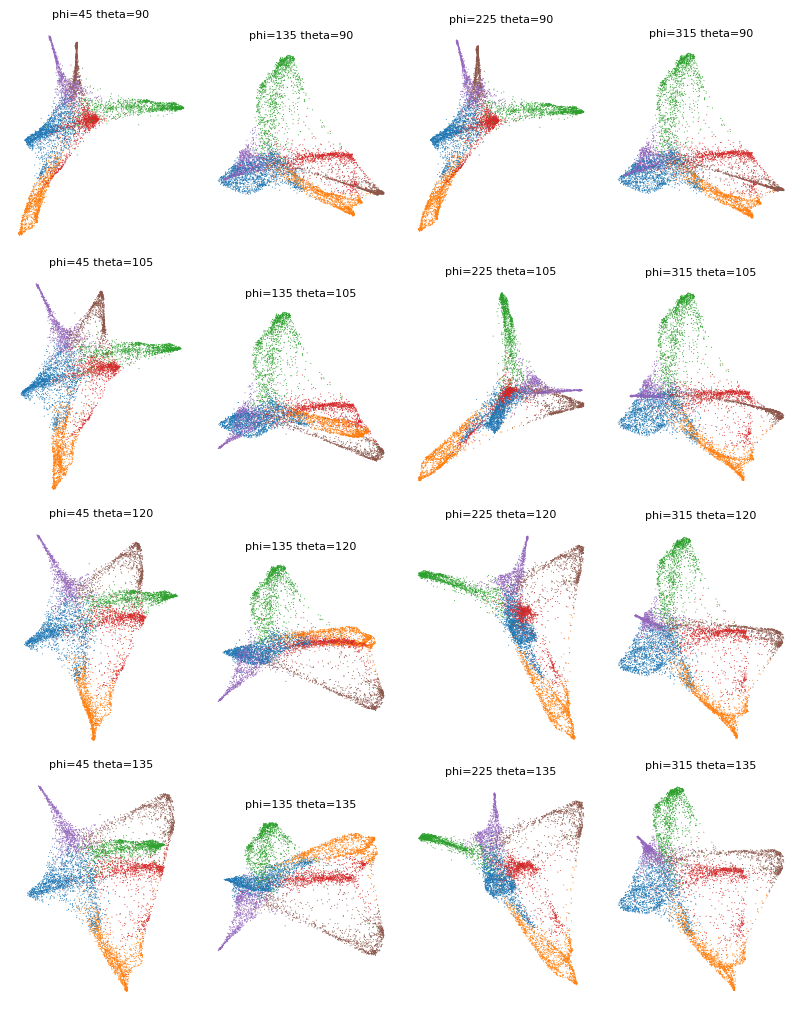

In [11]:
cdict = {'TAC-1': '#1f77b4', 
         'IRS - Henle\'s layer': '#ff7f0e', 
         'HS - Cortex': '#2ca02c',
         'TAC-2': '#d62728',
         'IRS - Huxley\'s layer': '#9467bd', 
         'HS - Medulla': '#8c564b'}

oci.pl.projections(adata, x='X_fa2', c='celltype', phis=[45, 135, 225, 315], 
                   thetas=[90, 105, 120, 135], cdict=cdict, markersize=0.5, 
                   fontsize=8, figsize=(8, 10), showlegend=False, random_state=SEED)

Select a projection for further analysis: `phi=135` and `theta=135`.

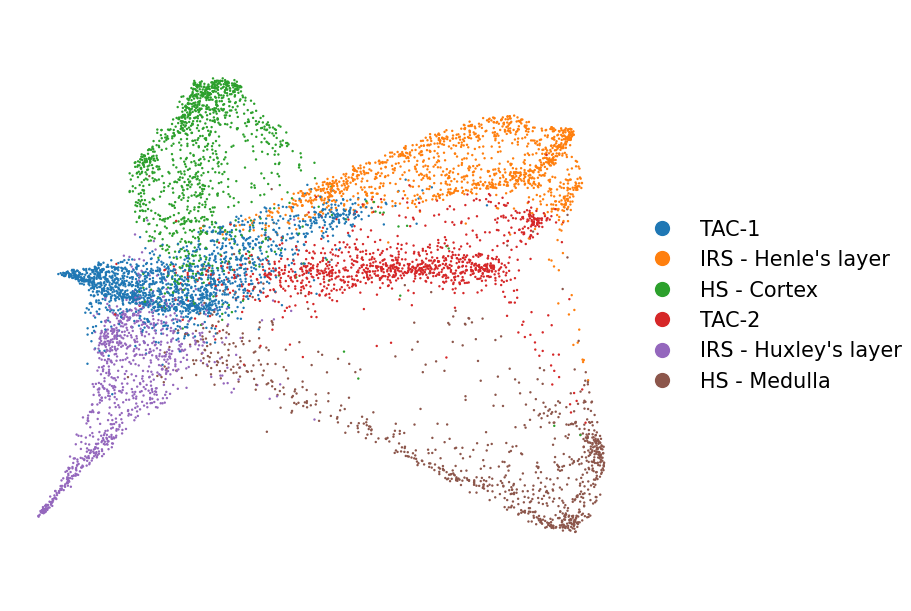

In [12]:
oci.tl.projection(adata, x='X_fa2', phi=135, theta=135, random_state=SEED)
oci.pl.scatter(adata, x='X_proj', c='celltype', cdict=cdict, markersize=3, markerscale=2, 
               fontsize=15, figsize=(9, 6), title='')

You may validate RNA velocities' quality by plotting the velocity stream with scVelo.

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_proj', embedded velocity vectors (adata.obsm)


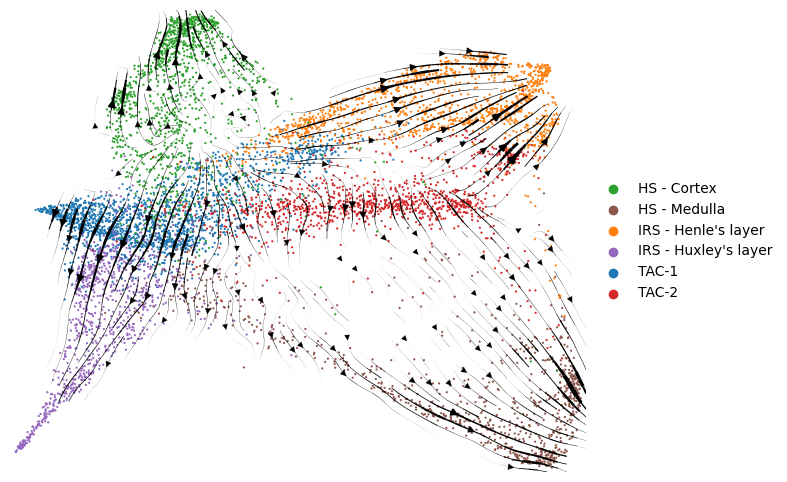

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 6))
scv.pl.velocity_embedding_stream(adata, basis='proj', alpha=1, title='', density=2,
                                 linewidth=2, show=False, ax=ax, color='celltype', 
                                 size=10, legend_fontweight=2, legend_loc='right center', 
                                 palette=cdict)

ax.set_aspect('equal')

## Interpreting multimodal weights

You can investigate multimodal weight distribution in multiple ways. For example, as in Tutorial 1, with scatter and violin plots.

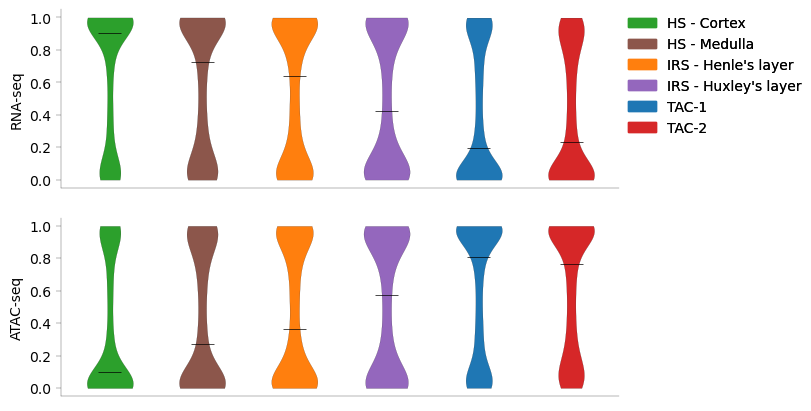

In [14]:
oci.pl.violin(adata, groups='celltype', values='weights', cdict=cdict, fontsize=10, 
              figsize=(8, 4))

Another option is bar plots which show the median or mean weight value per cell group.

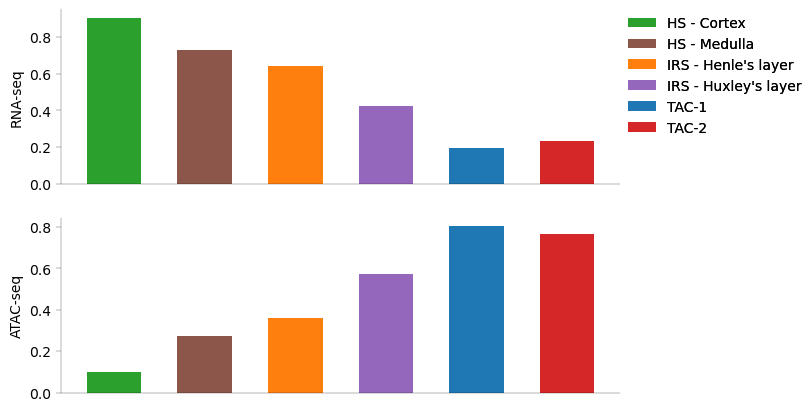

In [15]:
oci.pl.bar(adata, groups='celltype', values='weights', height='median', cdict=cdict, 
           fontsize=10, figsize=(8, 4))

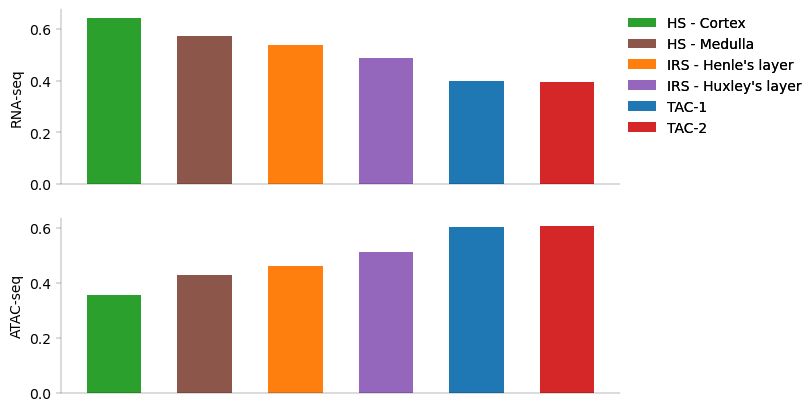

In [16]:
oci.pl.bar(adata, groups='celltype', values='weights', height='mean', cdict=cdict, 
           fontsize=10, figsize=(8, 4))

ATAC-seq is a more informative modality for transit-amplifying cells (TACs) and RNA-seq for hair shaft (HS) and inner root sheath (IRS).

## Analyzing gene signatures

If you have unannotated cells (or you wish to validate existing annotations), inspecting gene markers or gene signatures should help understand your dataset's biology. The hair follicle system was studied in detail by [Yang et al., 2017](https://www.sciencedirect.com/science/article/pii/S0092867417303677), resulting in gene signatures for HS and IRS cell subtypes.

In this section, you will examine hair follicle gene signatures with [z-scores](https://en.wikipedia.org/wiki/Standard_score), a statistic that measures how many standard deviations a value deviates from the mean. A high z-score for a cell indicates that a gene is expressed above the mean. For a gene signature, z-scores are computed for each gene individually and then averaged.

Firstly, log-normalize RNA-seq counts.

In [17]:
import scanpy as sc
import pandas as pd

rnasig = ad.read_h5ad('hair_follicle_RNAseq.h5ad')

sc.pp.normalize_total(rnasig, target_sum=10000)
sc.pp.log1p(rnasig)

`oci.tl.mean_z_scores` computes mean z-scores for a signature specified by a list of column indices of the count matrix.

`get_indices` converts a list of gene names into a list of `rnasig.var` indices.

In [18]:
def get_indices(signature, varnames):
    indices = list()

    for gene in signature:
        if gene in varnames:
            indices.append(varnames.index(gene))

    return indices

### Hair shaft (HS) gene signatures

Plot z-scores for HS gene signatures.

2023-02-09 17:54:01,204	INFO worker.py:1518 -- Started a local Ray instance.


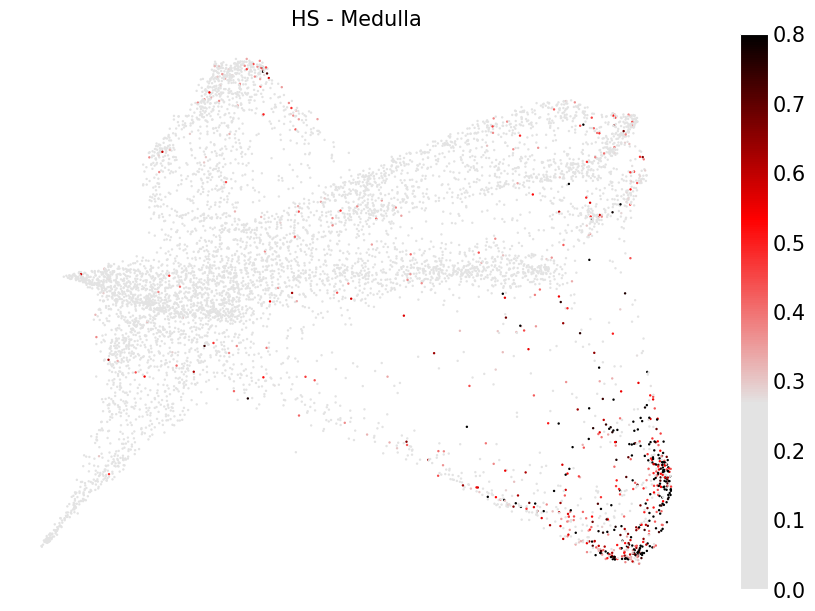

In [19]:
from matplotlib.colors import LinearSegmentedColormap

# define a custom colormap
sig_cmap = LinearSegmentedColormap.from_list(
    'custom', ['#e3e3e3','#e3e3e3', '#ff0000', '#000000'], N=256)
# listed rnasig column (gene) names
varnames = list(rnasig.var.index)

# load gene signature
markers = list(pd.read_csv('hair_follicle_signature_HS_Me.csv', index_col=0).index)
# gene signature name
name = 'HS - Medulla'

# compute z-scores
oci.tl.mean_z_scores(rnasig, markers=get_indices(markers, varnames), out=name)
# save z-scores to adata and plot
adata.obs[name] = rnasig.obs[name]
oci.pl.scatter(adata, x='X_proj', c=name, cmap=sig_cmap, markersize=3, markerscale=2, 
               fontsize=15, figsize=(9, 6), title=name, vmin=0, vmax=0.8)

2023-02-09 17:54:13,210	INFO worker.py:1518 -- Started a local Ray instance.


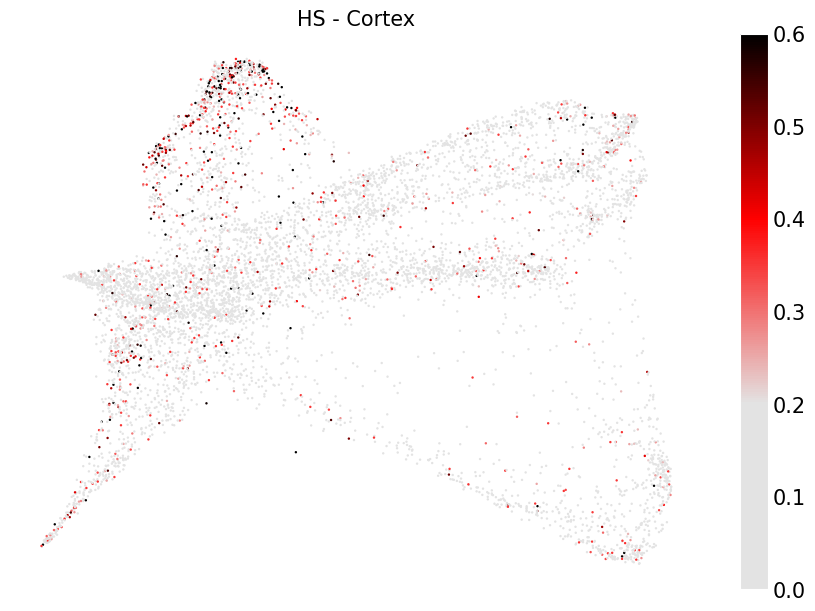

In [20]:
markers = list(pd.read_csv('hair_follicle_signature_HS_Co.csv', index_col=0).index)
name = 'HS - Cortex'

oci.tl.mean_z_scores(rnasig, markers=get_indices(markers, varnames), out=name)
adata.obs[name] = rnasig.obs[name]
oci.pl.scatter(adata, x='X_proj', c=name, cmap=sig_cmap, markersize=3, markerscale=2, 
               fontsize=15, figsize=(9, 6), title=name, vmin=0, vmax=0.6)

### Inner root sheath (IRS) gene signatures

Plot z-scores for IRS gene signatures.

2023-02-09 17:54:19,023	INFO worker.py:1518 -- Started a local Ray instance.


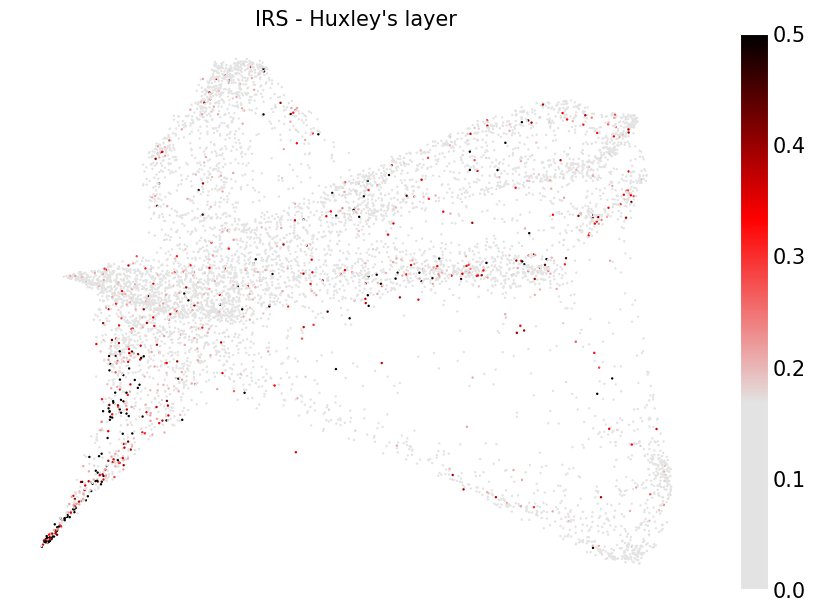

In [21]:
markers = list(pd.read_csv('hair_follicle_signature_IRS_Hu.csv', index_col=0).index)
name = 'IRS - Huxley\'s layer'

oci.tl.mean_z_scores(rnasig, markers=get_indices(markers, varnames), out=name)
adata.obs[name] = rnasig.obs[name]
oci.pl.scatter(adata, x='X_proj', c=name, cmap=sig_cmap, markersize=3, markerscale=2, 
               fontsize=15, figsize=(9, 6), title=name, vmin=0, vmax=0.5)

2023-02-09 17:54:26,105	INFO worker.py:1518 -- Started a local Ray instance.


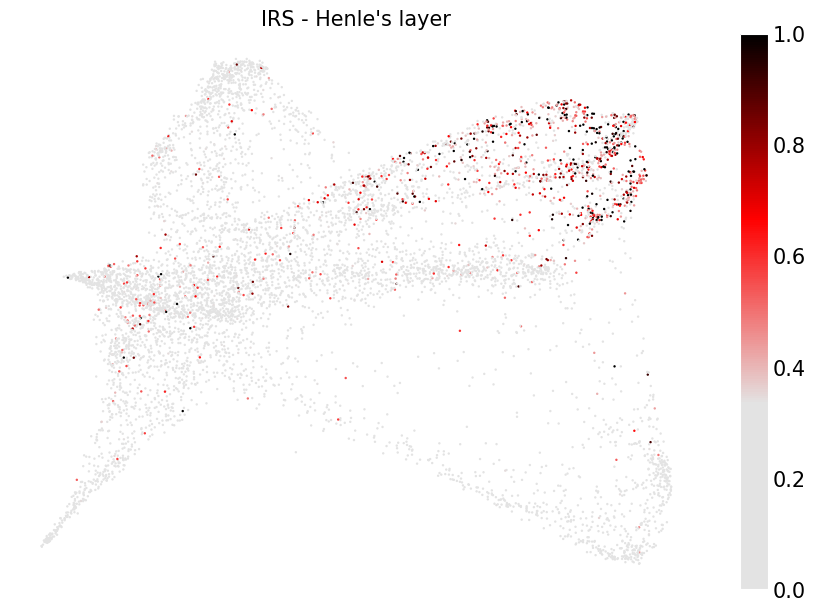

In [22]:
markers = list(pd.read_csv('hair_follicle_signature_IRS_He.csv', index_col=0).index)
name = 'IRS - Henle\'s layer'

oci.tl.mean_z_scores(rnasig, markers=get_indices(markers, varnames), out=name)
adata.obs[name] = rnasig.obs[name]
oci.pl.scatter(adata, x='X_proj', c=name, cmap=sig_cmap, markersize=3, markerscale=2,
               fontsize=15, figsize=(9, 6), title=name, vmin=0, vmax=1)

Investigation of gene signatures concludes Tutorial 2. In Tutorial 3, you will explore a bimodal single-cell dataset of human bone marrow.